In [30]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import urllib.request
from PIL import Image
from cv2 import resize
from keras import backend as K
from keras.layers import Input
from keras.layers.core import Activation, Dense, Flatten
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
from keras.layers import Conv2D
from keras.regularizers import l2
from keras.layers.core import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras.utils import layer_utils
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras import layers
import pathlib
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # You need to tell CUDA
# which GPU you'd like to use. if you have one GPU probably your GPU is '0'

In [31]:
def VGG16_Places365(include_top=True,
                    input_tensor=None, input_shape=None,
                    pooling=None,
                    classes=3):

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Block 1
    x = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block1_conv1')(img_input)

    x = Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='t_block1_conv2')(x)

    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block1_pool", padding='valid')(x)

    # Block 2
    x = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block2_conv1')(x)

    x = Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='t_block2_conv2')(x)

    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block2_pool", padding='valid')(x)

    # Block 3
    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv1')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block3_conv2')(x)

    x = Conv2D(filters=256, kernel_size=3, strides=(2, 2), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='t_block3_conv3')(x)
    
    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block3_pool", padding='valid')(x)

    # Block 4
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block4_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(2, 2), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='t_block4_conv3')(x)

    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block4_pool", padding='valid')(x)

    # Block 5
    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv1')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='block5_conv2')(x)

    x = Conv2D(filters=512, kernel_size=3, strides=(2, 2), padding='same',
               kernel_regularizer=l2(0.0002),
               activation='relu', name='t_block5_conv3')(x)

    #x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="block5_pool2.0", padding='valid')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='drop_fc1')(x)

    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='drop_fc2')(x)

    x = Dense(365, activation='softmax', name="predictions")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = Model(inputs, x, name='vgg16-places365')

    if include_top:
        weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5',
                                WEIGHTS_PATH,
                                cache_subdir='models')
    else:
        weights_path = get_file('vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models')

    #model.load_weights(weights_path, by_name=True)

    return model

In [3]:
train_data_dir = "D:/Downloads/places365_tiny/train/"
val_data_dir = "D:/Downloads/places365_tiny/val/"

train_data_dir = pathlib.Path(train_data_dir)
val_data_dir = pathlib.Path(val_data_dir)

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_data_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15000 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [4]:
train_class_names = train_ds.class_names
val_class_names = val_ds.class_names

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

WEIGHTS_PATH = 'https://github.com/GKalliatakis/Keras-Application-Zoo/releases/download/0.1/vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/GKalliatakis/Keras-Application-Zoo/releases/download/0.1/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0015006606 1.0


In [5]:
model = VGG16_Places365()

from keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit(train_ds, validation_data=val_ds, steps_per_epoch=10, validation_steps=10,epochs=10,callbacks=[checkpoint,early])

Model: "vgg16-places365"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
t_block1_conv2 (Conv2D)      (None, 112, 112, 64)      36928     
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
t_block2_conv2 (Conv2D)      (None, 56, 56, 128)       147584    
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
_________________________________________________________________
block3_conv2 (Conv2D)        (None, 56, 56, 256)   

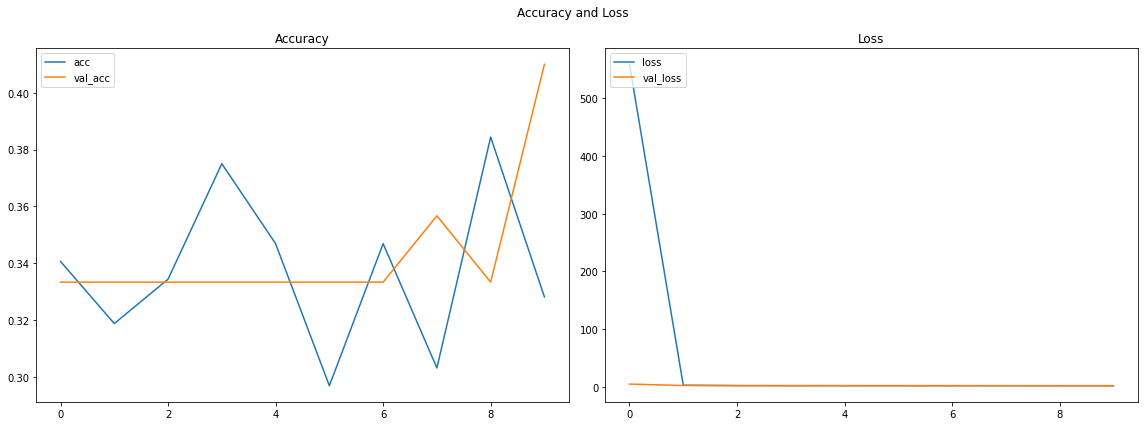

In [29]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
fig.suptitle("Accuracy and Loss")
axes[0].plot(hist.history["accuracy"], label="acc")
axes[0].plot(hist.history['val_accuracy'], label="val_acc")
axes[0].set_title("Accuracy")
axes[0].legend(loc="upper left")
axes[1].plot(hist.history['loss'], label="loss")
axes[1].plot(hist.history['val_loss'], label="val_loss")
axes[1].set_title("Loss")
axes[1].legend(loc="upper left")
fig.tight_layout()
fig.show()

In [7]:
TEST_IMAGE_URL = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxISEhUSEhIVFRUVFRUVFRgVFxUYFxUVFRUWFhcVFRUYHSggGBolHRUVITEhJSkrLi4uFx8zODMsNygtLisBCgoKDg0OFQ8QFysdHR0tLS0tLS0tLS0tLSstLS0tKzErLSstKy0tLS0tLS0tLSstLS0tLS0tLS0rKy0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAbAAACAwEBAQAAAAAAAAAAAAACAwABBAUGB//EAD8QAAEDAQQHBQUFBwUBAAAAAAEAAhEDITFBUQQSYXGBkaETscHR8AUGIlLhBxRCgvEWIzJicpLSFTNTosJE/8QAGQEBAQEBAQEAAAAAAAAAAAAAAAECAwUE/8QAIxEBAAICAgICAwEBAAAAAAAAAAERAhITUSFBAxQEMWEicf/aAAwDAQACEQMRAD8A9M0IwFAEYC9u3karARAKwEQCllIAiAVgIgEs1CAihWArhLSlQrhEArhSzUMK4RQrhLNQQrhFCkJZqGFUJkKoSzUEKQjhSEs1BCqEcKoSzUEKiEyEJCtmpZCohMIQkK2UWQhITCEJCWUUQhITSEJCtlEkICE4hAQrZqS4JbgnuCW4K2akOCWWp7glkJZRDmK0wqKWtOmAjCoBGAuNutLCMKgEYCWUsIgqARAKWaoEQCgCsBLNUVhXCuFLTVSsBWArhLXVUKQihXCWaghSEcKQlmpcKQjhSEs1LVJkKoSzUtQhFCkK2alkISE0hUQlmpJCEhNIQkK2alEICnEICFbNSSEJCcQgITY1IIS3LQ5qW5quxqzuQFPc1LLU2NSiFEwtVKbGrpBGEsIwuTqYEYSwilAwIglBGEBhEEARBEErQqwgJWhVqAlFSiC1FSiC5VSoqVElUoqQRUoqQWhKioqiihKsoSgEoSiKAqgSgKIoCqAKByNyW5CgOSyjcgKFKKioqKJTX27fmHMJrKgNxB3FfFSKpBJDpwR6PpekNtGuLZsz9Svj+1j0+z609vtbSilfGW+2tMpscWPqhwiAZNpvsW6j736cWidYWfJblbYtR+Tgz9fJ9aBRgr5bT98dNBtgiIgsxzsxQVPevTTA1iBM2N7ziNiv2ME+vk+rgogV8uHvnpmQtMj4DZhq7sUz9tdM+Uf2FXnwODJ9OlWHL5ponv3pAI12Ndn8JaZ4XJr/AH5r4UxM5HuTmw7TgzfR5Vyvnehe/NZv+5TD7drY6Lc33/b/AMDv7hxwVj5cJ9pPw5x6e3lSV4qn9oNO3WoPBGRBt6JjPtBoawBpVAIv+EwcolXkx7Tjy6eylSV5L9vNG+Wpyb/ki/bvRZuqRnqjhFqu+PZx5dPVSqleXb786LFuuNkDzRUvffRTElzc5F3KU2x7Tjy6ellSVwne9uhgW1b7vhdbbGSW/wB7aA/BVnLUjjertj2aZdO/Kkrl+y/blOvV7MNe0QJe9paGkkZ32ax4LDpfvN2Q1qmjVg222LLLb91qnJjdWvHl09CShJXi9I9/2g/DRne+DtuBWJ32gPJspNaIOJcZ5tsvTlx7Xhz6e/JVEr5xU9+NKGFLg09Zcrd7+1/kpbbHW/8AZOXFeHJ9DJQkr55+3mkE2U6W0AOPXWUb9oFW2aVON7hHGU5cO04c+n0AlASvA/t/UJspMjC13C1BU+0JwAmiy+J1jfHmnNh2cOfT3pKBxXz5/wBoFX/ipx+aY3yiPv6+/smxfeeSc/x9nDn0924pReJiV8z0v7QKzydVrWC6yTdeuK/3m0hztc1CCSSIuiFifycPTUfj5T+32R1UA2kKL49X95tIc4uNS/ICO5RY+1j019aXv/utP5WcG/VUdBpn8I5R4pTNCqY12D+liP7obzXcf6WtE814/Fk9PkxX9ypD8PV3+SYNHoXao6+aVU0Jpn95UmM2gcgEDfZrYtc85/Hee9XhyTkhr+70BewdR4oY0eJLWD8xHSUv/TWG9s75PVOZoLBc0Dl4rUfDPacsdAB0b+Wf6j5pug1dBFRvbHVp26xBfAEG0nATCcxoFxA5eCCvo2sCO0IBv1SB1haj4q9pPyX6D7x0vY4pOfolcVKsyAxzniSDAdkCcdiysNOB+4qEwJNoBOMAlFonsmjSkNL7bxIg7TZftvXS7XerPxRLWX5HyZ1vlOVd+XPp0mn/AOd43vA7iUf3LKlxNQ+S2GscCpaceQV4oY5JYhoB+RvGo49zQku0d7HBzS9pEj9w57DbF73NdZwXQBP80Zx4X9EJ0oD8NQ/kd3RKcePpMpn9SzVdAbU+LXc3ACPiMWaziRa43mwXo6XsmliC7eT3BbqNRxE6jh+W3kFdKs4m2m9ozIHdMrVRBEZTFgpaC1tjaYH5QmDRD8v/AFXL9t6SXFjG09ILNaahptLXERYASRjuR6FUrubq6tSm0EwakF2qDYCb3mIy3rpVY3bjGUzlrU/9dE6OBgOSJrLLB0CCgbJ+M/1WdPNP7RZt0mK/ZRaZm1Jr0DdIjbPS0QVsJOxC0yN21VHm6/sBx/hqNAnFpz/qhK/0ao2CXizCCRzm1epCF7d6zOMLtLz59nugwabjFgJLbd5CyP0WoD8VK04A6wgX6pAOzBekqN2nmkubaDiLRcSDmDeFmfjhqM5eTp67DLywcHNOy8KnMccKRxx8l7IaW7GHD+YA+E9UmrT0d/8AFRaDm2w+uKxxT6lrl9S8l93dbIpDKJu5IXaLd8FMwbbcNll69PU9h0nD4HFs5253XxeufpPu/XH+3qPG+3uWZwzhYzxcerojdWxrZ3rmVNFq3FlMjOR3Ls6T7OrsEvpRt12xuthYi2sL6br98bSWzCz/AKhq8XLf7KdF1LdKw6V7Le22GRsJNmQC72kVQwfE5oxiSDd/MO7MJT9KGADpMAAttMTE3XApGWSTEe3m9RuXUqL2FH2c+o0PDacESP3rB0Ki1vl0f5/j1oIRcEmckbV9LgY1+wK3VclTWFN1UCg8+ioX7E9tParDEGbtDl1KsVD8vVaXNQwpZQGuOQ5o7dnH6ICY9FEHEoDbV2BWdIIy5/RAHIu09BBbazshz80Ydb9Qq7VTX2W7AgZrn1CgJ29ENOuDjejdV29yCExn0Qa52otYKxBxVAGpmoCck/svVqLsSf1QZ43dVbb/AFimmiQlOZmgMt3KjwS7+Fn1VlwhBb9yS5pRg2XlBr70C3MOHJA8HEJpKrtSNvrNApk4GNkeBREvyB6eCYSHbdhUgqBRrnHraqNYG9rTukc0clLcgRV0RhN5b1HD9Fhre79F1zo3fCTyAXSJ2qifUrM4xKuI/wB1RP8AG7+76KLs2KLGkdLtPYmsCc0IA2U0MGJXS2aEIzRtj9UIAwCLUVUVmYRCPmHMWoAxWWGbAIxstRDuzyM7lHUTkLp9T3IGNzB6hNbsnmVfCeS+yjLgpqeoWhtQ7DvTWOwLRGMFPBcsJYFGs2rfqU8iOSYzR2kWEcY+iUW5hZtVFi6NTQX4QeXis7tBfrCGGY4RmRZKUXDnii4OMRBt44kIy0+guo32e7+UcfIIRoQxe0bre9C4c0SEQqkegumNHZ8/IeRVllO60+toQtzRpJUOlHIcgui9tPBhO+PApL9XCmBvxQYzpXqAq7bYF0O2IuY0cPJC7SqmwcPNBgLjfHQoe0GxPe55xvGQB3SLUl7n3FzuZQVrDMIXRsSzO1CZz7kUZHqUDpz70BLs0Bcc0BOCgrkX29/NBrIS8oH9sFRfOCyuKEPhC2mdiEu2dUrtVXaKBusMlEsnYrUpGmmWiwDwR9sBggdUBNjWxG/ySm0gcI/u/wAoV8Fy0ips5ou0OzopSaR+I7gE0nWvk75V8HlVMuNw6FMg5jmO5CxgFzeQVl0fhPrilwVInPIVa5P1QGpshWl/wr+n9sBENnO0pjK4+Xv84Wb1im0wdvVLKahpdn8IEbvJD95ddPril2ZKTP8ADZmfAeaWVAxpLrgegMdEdPSXC4naqFIC5vf5pdR2w8ksptp+0HC8TxIRO0xjr6Q6H6rBwKsDZ65pZTV+7NzQN5IjwVnRhZBvMXtNvArHwCcGjLollGVNEeMjuKUaD7Dqnoi1tp5I21sxPA+CeDyyVQ4Xg8R5odc5dy6jtLstDu/vCX2zCLQNkiCeICUW5zqhSta1dVujtdd0cDxhA/QHYETfGNiUXDmubsKWWbFudoztmd/mkOZCKzFmxA6nsWhzdqB+8IM5pjLuQljchyTXFAX7kCnUglupBaO0CFxCDG+kqa1aXEZJYLcfFAsnfy8lEw6ufeosocGZ+uCMOHoJDyRFkbcuqaBtd0HcitFOq3Bw9bk11WLysbRFwib5vPFGCdnVFNdVH1xKtsbeZSg7cj1zsVDNyoWmwTwKjQTlwKaJwHciIwRjbulEK5M2XX3eJUjM8goymTfIyEd6gJpJwgdTyuCZIxjdFvCxG2nZege7ARyQLqaRHwgOgYwfFVTrZSiDSo1uwcvqgMuMYpQeROPBPh2CUQSbfXVFHo7pWrW2rOKW3l5ogALrd9veqhhJzHVVrHNAXnDuUDzl0PmoLr1CG34pBqHNN0h9gkHkVmc/ZCovWOaEuKAv9WK9dUHo1QyRxF2PrqtB1vULCSR8WXdj4HgtdOoFBTpy7kkvN0JrnpbjtQZ6llsGEpzhkVstKy1KMG/ogQ47Fba2ChYRienklubtKBlcm8ehs2rL94aXavxE4kCwbyMUxsY9fqERjBABe3PvVIi7eoogTVcCALQTdiNt9oTAUqmItgd5TWuOQUaNa4580xpOxJDjkjG7qqDDjgmMYLyeiGnAw6pzXjIoGMIzVyMhKVrDAEnf1KYxmrjadylqaxmMiefJEbUnb4hA+rBx6fqlI01HEDbvuSxGJPEpAq5hNY/H10QNDAjYNp5lLFaPRV/eAgY5u2OJRspnaeP1WM1iTeBzTO2GJVGiybdbme+VZptzd/c7zWc6SgNYHDqfBEanUd/MoOzG3m7zWcaSQY8bUztZvtQFVYNvMoDTB9FVWrMAE8FTKgwnqqFuoZePmlO0c7uLvNNdV2qu19XoFim4Y2b1dIRZLrMoNmHrYnAtItsS3DVIcDkDuwPCepQNjJ3MfVC+f5eo80TZE3X+r0qqTbaJUUFSpF45GzwKAV25gbDI70tjhjfjPmo+FUFVB2cSFleSMRzVtsNk6sWibJ2BBUdGfNFJqQbwO/xV06oG7d9VRI2qj6vURo1lFnM5KKCgdngVQrkfNyBRNtw7+6E1p1cz+V3kihY85jjYVpbUAvCS/VIn/wAuQMLbgRIwPgCg6DagOKaHYDnkucS38Vk4iFoB1RYSR6wT9q3MIG31ima3qxYGOB28+5NfAuFu8pSWe+uBks5dKjWTffvTGtAx6oFF2wlFTZsNvRaGNG3mmaozKBUHAHqhdOSa7+opTQTj08UEY0/L63IuzKYGbTyRBpzlVCuzGxUCNncmlp2cyqdZeG80AATh1Rauw9EtsZAbvMFWakYE8CqKrMs/VA3emueDioCECng/ogsxnkETom7ol68ZhBDqjEW5lBrggtgnAxPkrqmdvJLg4OI3mRPHzQaaFWR+KRYeCZrSJ75+i57Krg6TaDZZmNh2bcFuFVuY4gKKpzJ/EO7vCRUYB+soqp2Dksz6zZsHLzQGbELrcFQflG69AXHJEIqNIwSzItTnPGLJ4nuSC5pNnVBZeoqLT8qigbRpmceZ80bmgWq1EVVJiBjA51gUUUvzSzHhuqUxFoSaMRxVqKoJrwDGy1H94FgPdf1UUVQ4HIImuKiiKNo2qy0K1EAko2FRRQWTCk2XqKKouJF5tS2tcLoPQq1EWhdvn66oNebj3qKIgicPEoIGSiiCaoN08yqLYUUQKcN3VC4wooqAeyRZGYs4q2EkA5hUoorPpYgNgkN1wHRkbO8hSuLQJs3AKKKoHWGM8Y8FHRmoogA1TdI6pdQnHFRRQJIOxRRRQf/Z'

image = Image.open(urllib.request.urlopen(TEST_IMAGE_URL))
image = np.array(image, dtype=np.uint8)
image = resize(image, (224, 224))
image = np.expand_dims(image, 0)

predictions_to_return = 5
preds = model.predict(image)[0]
top_preds = np.argsort(preds)[::-1][0:predictions_to_return]

# load the class label
file_name = 'categories_places365.txt'

classes = list()

with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

print('--SCENE CATEGORIES:')
# output the prediction
for i in range(0, 5):
    print(classes[top_preds[i]])

--SCENE CATEGORIES:
airport_terminal
airplane_cabin
airfield
racecourse
stadium/soccer
